# 巴西预约挂号求诊信息的探究

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

本次分析我们想探究这样几个问题：
- 患者的年龄大小是否会影响就诊率的变化？  
- 病人拥有福利保障是否会提高就诊率？

In [1]:
# 导入模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
# 配置matplotlib图表中文字体
import matplotlib.font_manager as fm
myFont = fm.FontProperties(fname='C:\Windows\Fonts\simhei.ttf', size=20)

<a id='wrangling'></a>
## 数据整理

在数据分析之前，为了方便调用和处理，我们先简单对数据进行整理，如：查看属性、去重、处理空值、修改类型等工作。

### 常规属性

In [2]:
# 加载数据
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
# 查看数据信息，包含每列的数据类型以及是否有缺失数据的情况
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
# 打印前5行数据
df.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

| 列名           | 非空数量 | 数据类型 | 含义                      |
| -------------- | -------- | -------- | ------------------------- |
| PatientId      | 110527   | float64  | 默认id                    |
| AppointmentID  | 110527   | int64    | 预约卡id                  |
| Gender         | 110527   | object   | 性别                      |
| ScheduledDay   | 110527   | object   | 预约时间                  |
| AppointmentDay | 110527   | object   | 预约卡办理时间            |
| Age            | 110527   | int64    | 年龄                      |
| Neighbourhood  | 110527   | object   | 所属街区                  |
| Scholarship    | 110527   | int64    | 福利保障(1)               |
| Hipertension   | 110527   | int64    | 高血压(1)                 |
| Diabetes       | 110527   | int64    | 糖尿病(1)                 |
| Alcoholism     | 110527   | int64    | 酗酒(1)                   |
| Handcap        | 110527   | int64    | 残障(1)                   |
| SMS_received   | 110527   | int64    | 收到短信(1)               |
| No-show        | 110527   | object   | 未就诊标记(Yes表示未就诊) |


### 数据清理

首先对数据集中的空值和冗余数据进行处理

In [5]:
# 查询空值数量
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [6]:
# 查询冗余行
sum(df.duplicated())

0

> 通过上面的命令，该数据集没有空值和冗余行，故无需进行空值和冗余处理操作

观察发现该数据集中的列名不是很统一，并且首字母大写，不便于后期的处理和分析，故现在将对列名进行处理

In [7]:
# 修改列名
# 将所有大写变小写
# 并将‘No-show’列中的‘-’改为‘_’
df.rename(columns=lambda x:x.strip().lower().replace("-", "_"), inplace=True)

In [8]:
# 查看列名是否已修改
df.head(1)

patientid  appointmentid gender          scheduledday  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   

         appointmentday  age    neighbourhood  scholarship  hipertension  \
0  2016-04-29T00:00:00Z   62  JARDIM DA PENHA            0             1   

   diabetes  alcoholism  handcap  sms_received no_show  
0         0           0        0             0      No

接下来修正数据类型  
> 将`scheduledday`和`appointmentday`改为日期类型


In [9]:
# 修改数据类型
df.scheduledday = pd.to_datetime(df.scheduledday)
df.appointmentday = pd.to_datetime(df.appointmentday)

In [10]:
# 查看数据类型是否改变
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null datetime64[ns]
appointmentday    110527 non-null datetime64[ns]
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


为便于后期的数据分析，`no_show`一列的内容值为YES和NO，同样为便于后期的数据处理，将要对该列中的值进行修改

In [11]:
# 修改`no_show`列，将YES改为1， NO改为0
df.no_show = df.no_show.map({'No':0, 'Yes':1})

In [12]:
# 查看修改情况
df.head().no_show

0    0
1    0
2    0
3    0
4    0
Name: no_show, dtype: int64

对于数据的清理工作基本已经完成，下面就对该数据集进行探索性分析。

<a id='eda'></a>
## 探索性数据分析


### 年龄与就诊率的关系

In [14]:
# 查看年龄的唯一值
df.age.unique()

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1],
      dtype=int64)

> 观察发现在年龄中有一项“-1”的值，这并不符合常理(年龄不可能有负值)，不论该数据如何出现，为不影响整体分析，先将年龄为-1的所有行全部删除

In [15]:
# 删除年龄为-1的行
df.drop(df[df.age==-1].index, inplace=True)

In [45]:
# 提取就诊的数据集
df_0 = df[df.no_show==0]

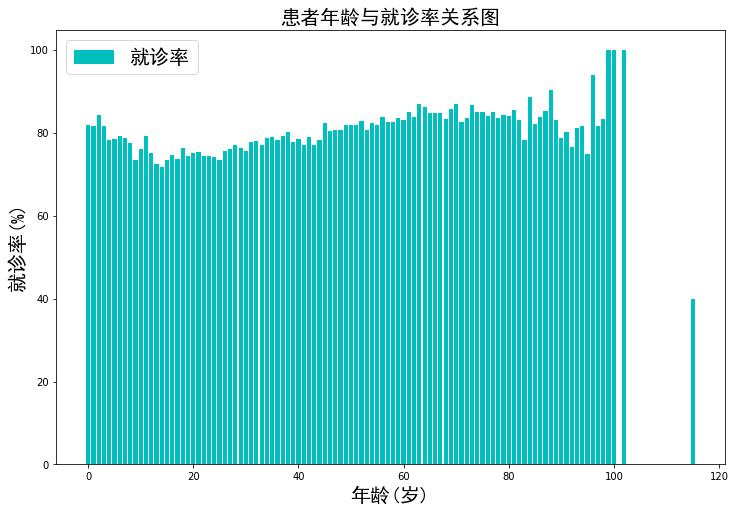

In [114]:
plt.figure(figsize=(12, 8))
x = df.groupby('age').no_show.count().index
y = (df_0.groupby('age').no_show.count() / df.groupby('age').no_show.count()) * 100
plt.title('患者年龄与就诊率关系图', fontproperties='SimHei', fontsize=20)
plt.xlabel('年龄(岁)', fontproperties='SimHei',  fontsize=20)
plt.ylabel('就诊率(%)', fontproperties='SimHei',  fontsize=20)

plt.bar(x, y, label='就诊率', color='c');
plt.legend(prop=myFont, loc=2, fontsize=10);

通过上图可见，随着患者年龄的增大，就诊率确有所提高，但变化并不明显，不能直接得出患者年龄与之有关的结论。

### 福利保障对就诊率的探究

In [66]:
# 无福利保障的数据集
df_no_scholarship = df[df.scholarship==0]

In [68]:
# 有福利保障的数据集
df_yes_scholarship = df[df.scholarship==1]

In [69]:
# 有福利保障的就诊率
show_num_1 = df_yes_scholarship[df_yes_scholarship.no_show==0].no_show.count()
show_count_1 = df_yes_scholarship.no_show.count()
visiting_rate_1 = show_num_1 / show_count_1
print(visiting_rate_1)

0.7626369579228433


In [70]:
# 无福利保障的就诊率
show_num_0 = df_no_scholarship[df_no_scholarship.no_show==0].no_show.count()
show_count_0 = df_no_scholarship.no_show.count()
visiting_rate_0 = show_num_0 / show_count_0
print(visiting_rate_0)

0.8019264536196258


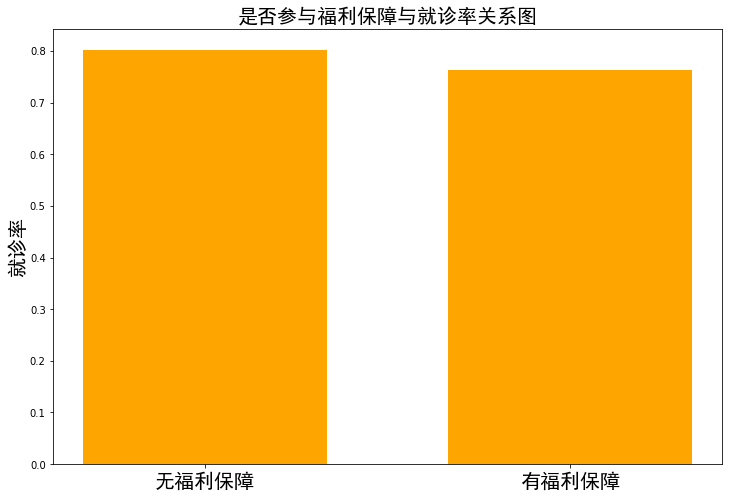

In [128]:
plt.figure(figsize=(12, 8))
plt.title('是否参与福利保障与就诊率关系图', fontproperties='SimHei', fontsize=20)
x = [0.5, 0.8]
group_labels = ['无福利保障', '有福利保障']
y = [visiting_rate_0, visiting_rate_1]
plt.xticks(x, group_labels, rotation=0, fontproperties='SimHei',  fontsize=20)
plt.ylabel('就诊率', fontproperties='SimHei',  fontsize=20)
plt.bar(x, y, label='就诊率', color='orange', width=0.2);

根据统计，参与福利保障计划并没有像想象中提高就诊率，两者相差甚微，甚至参与福利保障计划的就诊率还低于没有参与福利保障计划的患者。

<a id='conclusions'></a>
## 结论


本次分析仅简单从两个问题入手，分别证明了患者年龄大小仅轻微的影响就诊率的上升，而参与福利保障计划并没有想象中那样提高就诊率。对于本数据集还有很多列可供仔细分析，但限于个人才疏学浅，没有对更深层的问题进行探讨。学无止境，我相信本次分析仅仅是一个开始，本人的数据分析道路远走越走越远。在这里感谢助教老师的指导，以及同业同学的帮助。同时感谢评阅本报告的审阅老师，如在报告中出现技术疏漏望老师指正。

In [21]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

4294967295